In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, rdMolTransforms
import os
import fnmatch
import numpy as np
import deepchem as dc
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.mixture import GMM
import random
from tflearn.activations import leaky_relu
from deepchem.utils.rdkit_util import get_xyz_from_mol
from deepchem.feat.rdkit_grid_featurizer import convert_atom_to_voxel, compute_centroid, rotate_molecules
np.set_printoptions(precision=4)

In [2]:
from deepchem.feat.graph_features import ConvMolFeaturizer
from deepchem.feat.adjacency_fingerprints import AdjacencyFingerprint

In [3]:
def featurize_mols(mol_files, max_n_atoms):
    featurizer = AdjacencyFingerprint(max_n_atoms=max_n_atoms)
    features = []
    for idx, mol_file in enumerate(mol_files):
        if idx % 32 == 0:
            print(idx)
        try:
            bond_dist_mat = np.zeros((max_n_atoms, max_n_atoms))
            angle_mat = np.zeros((max_n_atoms, max_n_atoms, max_n_atoms))
            angle_tuples = np.zeros((max_n_atoms, max_n_atoms, max_n_atoms)).astype(np.uint8)
            
            if ".pdb" in mol_file:
                mol = Chem.MolFromPDBFile(mol_file)
            else:
                mol = Chem.MolFromMol2File(mol_file)
            mol_xyz = get_xyz_from_mol(mol)
            centroid = compute_centroid(mol_xyz)
            mol_xyz -= centroid
            temp = np.zeros((max_n_atoms, 3))
            temp[:mol_xyz.shape[0]] = mol_xyz
            mol_xyz = temp
            
            #mol_xyz = rotate_molecules([mol_xyz])[0]

            c = mol.GetConformer(0)
            
            n_bonds = 0
            n_angles = 0
            for bond in mol.GetBonds():
                n_bonds += 1
                atom_i, atom_j = (bond.GetBeginAtom().GetIdx(), bond.GetEndAtom().GetIdx())
                bond_dist_mat[atom_i, atom_j] = np.power(rdMolTransforms.GetBondLength(c, atom_i, atom_j),2)
                bond_dist_mat[atom_j, atom_i] = np.power(rdMolTransforms.GetBondLength(c, atom_i, atom_j),2)
                
                for sub_bond in bond.GetBeginAtom().GetBonds():
                    atom_k = sub_bond.GetEndAtom().GetIdx()
                    if atom_k == atom_j or atom_k==atom_i: continue
                    angle = np.cos(rdMolTransforms.GetAngleRad(c, atom_j, atom_i, atom_k))
                    angle_mat[atom_i, atom_j, atom_k] = angle
                    angle_mat[atom_i, atom_k, atom_j] = angle
                    
                    angle_tuples[atom_i, atom_j, atom_k] = 1
                    angle_tuples[atom_i, atom_k, atom_j] = 1
                    n_angles += 2
                    
                for sub_bond in bond.GetEndAtom().GetBonds():
                    atom_k = sub_bond.GetEndAtom().GetIdx()
                    if atom_k == atom_i or atom_k==atom_j: continue
                    angle = np.cos(rdMolTransforms.GetAngleRad(c, atom_i, atom_j, atom_k))
                    angle_mat[atom_j, atom_i, atom_k] = angle
                    angle_mat[atom_j, atom_k, atom_i] = angle

                    angle_tuples[atom_j, atom_i, atom_k] = 1
                    angle_tuples[atom_j, atom_k, atom_i] = 1
                    n_angles += 2
                    
            if mol is None:
                features.append(None)
                continue
                
            graph_feat = featurizer.featurize([mol])[0]
            
            features.append((mol_file, bond_dist_mat, mol_xyz, angle_mat, angle_tuples, n_bonds, n_angles, graph_feat))
        except:
            features.append(None)
    return(features)

In [4]:
import pickle
max_n_atoms = 12
S = 64
feature_file = "./voxel_features_pdbbind.pkl"
if not os.path.exists(feature_file):
#if 1== 1:
    pdbbind_dir = "/home/evan/Documents/deep_docking/datasets/v2015/"
    def find_files(directory, pattern):
        for root, dirs, files in os.walk(directory):
            for basename in files:
                if fnmatch.fnmatch(basename, pattern):
                    filename = os.path.join(root, basename)
                    yield filename
    ligand_files = []
    for f in find_files(pdbbind_dir, "*ligand.mol2"):
        ligand_files += [f]
    ligand_files = ligand_files[:] + ["/home/evan/Documents/deep_docking/alanine_dipeptide.pdb"]*S  
    features = featurize_mols(ligand_files, max_n_atoms)
    with open(feature_file, "wb") as f:
        pickle.dump(features, f, protocol=2)
else:
    with open(feature_file, "rb") as f:
        features = pickle.load(f)

In [5]:
features = [f for f in features if f is not None]

In [6]:
len(features)

994

In [7]:
features[-1][0]

'/home/evan/Documents/deep_docking/alanine_dipeptide.pdb'

In [8]:
features[0][1].shape

(12, 12)

In [280]:
import tensorflow as tf
tf.reset_default_graph()
alpha = 0.01
n_layers = 1

S = 32

B = max_n_atoms
p = 75

z_dim = 8

L_list = [p, 16, 64, 128, 256]

dihed_per_bond = 1
valence = 4



In [281]:
with tf.device('/gpu:0'):
    x = tf.placeholder(tf.float32, [S, B, L_list[0]], name="atom_features")
    keep_prob = tf.placeholder(tf.float32, name="keep_prob")
    
    adj_matrix = tf.placeholder(tf.float32, shape=[S, B, B], name="adj_matrix")
    
    #dist_matrix2d = tf.placeholder(tf.float32, shape=[S, B, B], name="dist_matrix2d")
    #bond_dist_mat = tf.placeholder(tf.float32, shape=[S, B, B], name="bond_dist_mat")
    
    #angle_tensor = tf.placeholder(tf.float32, shape=[S, B, B, B], name="angle_tensor")
    angle_tuples = tf.placeholder(tf.float32, shape=[S, B, B, B], name="angle_tuples")
    n_bonds = tf.placeholder(tf.float32, shape=[S,1], name="nbonds")
    n_angles = tf.placeholder(tf.float32, shape=[S,1], name="nangles")
    
    
    mol_xyz = tf.placeholder(tf.float32, shape=[S, B, 3], name="molxyz")
    
    z = tf.random_normal([S, z_dim], mean=0, stddev=1)
    
    mol_noise = tf.random_normal([S,B,3], mean=0,stddev=0.0001)


In [282]:
#adapted from: http://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow
def compute_distance_matrix(A):
    r = tf.reduce_sum(A*A, 1) # turn r into column vector 
    r = tf.reshape(r, [-1, 1]) 
    D = r - 2*tf.matmul(A, tf.transpose(A)) + tf.transpose(r)
    return(D)

In [283]:
GW_list = [None for i in range(n_layers)]
Gb_list = [None for i in range(n_layers)]

DW_list = [None for i in range(n_layers)]
Db_list = [None for i in range(n_layers)]


Gh_list = [x]
Dh_list = [x]

adj_list = [adj_matrix]
B_list = [B]
clades_list = []
graph_stride = 1.

print("building clades and adj")
for i in range(n_layers):
    print(i)
    B_list.append(int(np.ceil(B_list[i]/graph_stride)))
    print(B_list)
    clades_list.append(tf.stack([tf.one_hot(range(0,B_list[i],int(graph_stride)), depth=B_list[i])]*S, axis=0)) 


    adj_temp = tf.matmul(clades_list[i], adj_list[i])
    sub_adj = tf.matmul(adj_temp, tf.transpose(adj_temp, perm=[0, 2, 1]))
    sub_adj = tf.minimum(sub_adj, 1.)
    adj_list.append(sub_adj)

print("Building hidden layers")
for layer_idx in range(n_layers):
    GW_list[layer_idx] = tf.Variable(tf.truncated_normal([L_list[layer_idx], L_list[layer_idx+1]], seed=2017), name="GW_list%d" %layer_idx)
    Gb_list[layer_idx] = tf.Variable(tf.ones([1, L_list[layer_idx+1]]))
    
    DW_list[layer_idx] = tf.Variable(tf.truncated_normal([L_list[layer_idx], L_list[layer_idx+1]], seed=2017), name="DW_list%d" %layer_idx)
    Db_list[layer_idx] = tf.Variable(tf.ones([1, L_list[layer_idx+1]]))
    
g_w1 = tf.Variable(tf.truncated_normal([L_list[n_layers]+z_dim, 16*5]))
g_b1 = tf.Variable(tf.ones([1, 16*5]))

g_w2 = tf.Variable(tf.truncated_normal([16*5, B*3]))
g_b2 = tf.Variable(tf.ones([1, B*3]))

d_w1_ini = tf.Variable(tf.truncated_normal([1, B*(L_list[n_layers]*2+1), 32]))
d_w1 = tf.tile(d_w1_ini, [S, 1, 1])
d_b1 = tf.Variable(tf.ones([1, 1, 32]))

d_w2_ini = tf.Variable(tf.truncated_normal([1, 32, 1]))
d_w2 = tf.tile(d_w2_ini, [S, 1, 1])
d_b2 = tf.Variable(tf.ones([1, 1, 1]))

lam1 = tf.Variable(tf.constant(0.01))
lam2 = tf.Variable(tf.constant(0.01))

building clades and adj
0
[12, 12]
Building hidden layers


In [284]:
def adjacency_conv_layer(x, W, b, adj, clades, L_in, L_out, layer_idx, S, B):
    with tf.device('/gpu:0'):
        print("layer_idx: %d" %(layer_idx))
        h = tf.matmul(adj, x, name="adj_mult_%d" %layer_idx)
        h = tf.reshape(h, shape=(S*B, L_in), name="adj_reshape_1_%d" %layer_idx)

        h = tf.matmul(h, W, name="adjconv_%d" %layer_idx) + b
    
        h = tf.nn.tanh(h)
        h = tf.reshape(h, (S, B, L_out), name="adj_reshape_2_%d" %layer_idx)  

        h = tf.matmul(clades, h)

        print("within func h:")
        print(h)                                                                                                                              

    return(h)

In [285]:
#t = sess.run(tf.matmul(dihed_indices[:,:,:,0], x))
#t = np.reshape(t, [t.shape[0]*t.shape[1],t.shape[2]])

In [286]:
def generator(W_list, b_list, h_list, L_list, n_layers):
    for layer_idx in range(n_layers):
        h_list.append(tf.nn.dropout(adjacency_conv_layer(h_list[layer_idx], W_list[layer_idx],
                                                     b_list[layer_idx], adj_list[layer_idx], 
                                                     clades_list[layer_idx],
                                                     L_list[layer_idx], L_list[layer_idx+1],
                                                     layer_idx, S, B_list[layer_idx]), keep_prob))
    L_final = L_list[n_layers]  
    
    print("h_list[-1]")
    print(h_list[-1])
    
    print("B_list")
    print(B_list)
    
    h_final = tf.reduce_sum(h_list[-1], axis=1, keep_dims=False)
    h_final = tf.concat([h_final, z], axis=1)

    
    print("h afterz")
    print(h_final)
    
    g_h1 = tf.nn.dropout(tf.nn.tanh(tf.matmul(h_final, g_w1) + g_b1), keep_prob)
    #g_h1 = tf.reshape(g_h1, [S, 5, 16])
    print("g_h1")
    print(g_h1)
    g_h2 = tf.reshape(tf.matmul(g_h1, g_w2) + g_b2, [S, B, 3])
    #g_h2 = tf.clip_by_value(g_h2, -10., 10.)
    return(g_h2)



In [287]:
def compute_angle_tensor(mols_batch, angle_tuples_batch):
    i_vec = tf.reshape(mols_batch, [S, B, 1, 3])
    i_vec = tf.tile(i_vec, [1, 1, B, 1])

    j_vec = tf.reshape(mols_batch, [S, 1, B, 3])
    j_vec = tf.tile(j_vec, [1, B, 1, 1])

    diff = tf.subtract(i_vec, j_vec)
    temp = tf.eye(B, batch_shape=[S])
    temp = tf.reshape(temp, [S, B, B, 1])
    temp = tf.tile(temp, [1, 1, 1, 3])
    diff = diff + temp
    diff = diff / tf.sqrt(tf.reduce_sum(tf.square(diff), axis=3, keep_dims=True))
    temp = tf.sqrt(tf.reduce_sum(tf.square(temp), axis=3, keep_dims=True))
    diff = tf.subtract(diff, temp)

    print("diff should be [S, B, B, 3]")
    print(diff)

    ij = tf.tile(tf.reshape(diff, [S, B, 1, B, 3]), [1, 1, B, 1, 1])
    ik = tf.tile(tf.reshape(diff, [S, B, B, 1, 3]), [1, 1, 1, B, 1])
    dps = tf.reduce_sum(tf.multiply(ij ,ik), axis=4)
    #dps = tf.where(tf.is_nan(dps), tf.ones_like(dps) * 0., dps)
    print("dps should be [S, B, B, B]")
    print(dps)

    #angles_gen = tf.acos(tf.clip_by_value(dps, -1.0, 1.0))
    angles_computed = tf.where(tf.is_nan(dps), tf.zeros_like(dps), dps)
    angles_computed = tf.multiply(angles_computed, angle_tuples_batch)
    return(angles_computed)

def compute_dist_tensor(mols_batch):
    dist_matrix = tf.concat([tf.reshape(compute_distance_matrix(tf.reshape(mol, [B, 3])), (1, B, B)) for mol in tf.split(mols_batch, S, axis=0)], axis=0)
    #dist_matrix = tf.where(tf.is_nan(dist_matrix), tf.ones_like(dist_matrix) * 0., dist_matrix)
    print("dist_matrix")
    print(dist_matrix)
    #dist_matrix = compute_distance_matrix(mol)
    return(dist_matrix)

def compute_dihedral_tensor(mols_batch, angle_tuples_batch):
    i_vec = tf.reshape(mols_batch, [S, B, 1, 3])
    i_vec = tf.tile(i_vec, [1, 1, B, 1])

    j_vec = tf.reshape(mols_batch, [S, 1, B, 3])
    j_vec = tf.tile(j_vec, [1, B, 1, 1])

    diff = tf.subtract(i_vec, j_vec)
    temp = tf.eye(B, batch_shape=[S])
    temp = tf.reshape(temp, [S, B, B, 1])
    temp = tf.tile(temp, [1, 1, 1, 3])
    diff = diff + temp
    diff = diff / tf.sqrt(tf.reduce_sum(tf.square(diff), axis=3, keep_dims=True))
    temp = tf.sqrt(tf.reduce_sum(tf.square(temp), axis=3, keep_dims=True))
    diff = tf.subtract(diff, temp)

    print("diff should be [S, B, B, 3]")
    print(diff)

    ij = tf.tile(tf.reshape(diff, [S, B, 1, B, 3]), [1, 1, B, 1, 1])
    ik = tf.tile(tf.reshape(diff, [S, B, B, 1, 3]), [1, 1, 1, B, 1])
    cross = tf.cross(ij, ik)
    cross = cross / tf.sqrt(tf.reduce_sum(tf.square(cross), axis=4, keep_dims=True))
    
    ijk = tf.tile(tf.reshape(cross, [S, B, B, 1, B, 3]), [1m 1])
    
    dps = tf.reduce_sum(tf.multiply(ij ,ik), axis=4)
    #dps = tf.where(tf.is_nan(dps), tf.ones_like(dps) * 0., dps)
    print("dps should be [S, B, B, B]")
    print(dps)

    #angles_gen = tf.acos(tf.clip_by_value(dps, -1.0, 1.0))
    angles_computed = tf.where(tf.is_nan(dps), tf.zeros_like(dps), dps)
    angles_computed = tf.multiply(angles_computed, angle_tuples_batch)
    return(angles_computed)

In [288]:
def discriminator(W_list, b_list, h_list, L_list, n_layers, mols, mol_xyz):
    mols = tf.add(mols, mol_noise)
    print("mols")
    print(mols)
    with tf.device('/gpu:0'):
        for layer_idx in range(n_layers):
            h_list.append(tf.nn.dropout(adjacency_conv_layer(h_list[layer_idx], W_list[layer_idx],
                                             b_list[layer_idx], adj_list[layer_idx], 
                                             clades_list[layer_idx],
                                             L_list[layer_idx], L_list[layer_idx+1],
                                             layer_idx, S, B_list[layer_idx]), keep_prob))
        h_final = h_list[-1]

        #COMPUTE ANGLE LOSS:
        angle_tensor = compute_angle_tensor(mol_xyz, angle_tuples)
        angles_gen = compute_angle_tensor(mols, angle_tuples)

        
        wrong_angle_loss = tf.divide(tf.reshape(tf.multiply(tf.reduce_sum(tf.squared_difference(angles_gen, angle_tensor), axis=[1,2,3]), lam2), (S,1)), n_angles)
        #wrong_angle_loss = tf.where(tf.is_nan(wrong_angle_loss), tf.zeros_like(wrong_angle_loss), wrong_angle_loss)

        #wrong_angle_loss = tf.minimum(wrong_angle_loss, 3.14**2)
        print("wrong_angle_loss")
        print(wrong_angle_loss)
        
        #COMPUTE BOND LOSS:
        dist_matrix_gen = compute_dist_tensor(mols)
        bond_dist_gen = tf.multiply(dist_matrix_gen, adj_matrix)
        
        dist_matrix_real = compute_dist_tensor(mol_xyz)
        bond_dist_real = tf.multiply(dist_matrix_real, adj_matrix)

 
        wrong_bond_loss = tf.divide(tf.reshape(tf.multiply(tf.reduce_sum(tf.square(tf.subtract(bond_dist_real, bond_dist_gen)), axis=[1,2]), lam1), (S,1)), n_bonds)
        print("wrong_bond_loss")
        print(wrong_bond_loss)
        
        #COMPUTE DIHEDRAL LOSS?
        
        
        feat_i = tf.reshape(h_final, (S, B, 1, L_list[n_layers]))
        feat_i = tf.tile(feat_i, [1, 1, B, 1])
        
        feat_j = tf.reshape(h_final, (S, B, 1, L_list[n_layers]))
        feat_j = tf.transpose(feat_j, perm=[0, 2, 1, 3])
        feat_j = tf.tile(feat_j, [1, B, 1, 1])
        
        d_h1 = tf.concat([tf.reshape(dist_matrix_gen, [S, B, B, 1]), feat_i, feat_j], axis=3)
        d_h1 = tf.reshape(d_h1, [S, B, B*(L_list[n_layers]*2+1)])
        d_h2 = tf.nn.dropout(leaky_relu(tf.matmul(d_h1, d_w1) + d_b1), keep_prob)
        d_h2 = tf.divide(tf.reduce_sum(tf.matmul(d_h2, d_w2) + d_b2, axis=1), n_bonds)#, axis=1
        print("d_h2")
        print(d_h2)
        
    
    return(tf.add(tf.add(wrong_bond_loss, tf.multiply(wrong_angle_loss, 10.)), d_h2), bond_dist_gen, angles_gen, wrong_bond_loss, wrong_angle_loss)

In [289]:

theta_D = DW_list[:n_layers] + Db_list[:n_layers] + [d_w1_ini, d_b1, d_w2_ini, d_b2] + [lam1, lam2]

theta_G =  GW_list[:n_layers] + Gb_list[:n_layers] + [g_w1, g_b1, g_w2, g_b2]

In [290]:
import time 

with tf.device('/gpu:0'):    

    G_sample = generator(GW_list, Gb_list, Gh_list, L_list, n_layers)

    D_real, bond_dist_real, angles_gen_real, wrong_bond_real, wrong_angle_real = discriminator(DW_list, Db_list, Dh_list, L_list, n_layers, mol_xyz, mol_xyz)
    D_fake, bond_dist_fake, angles_gen_fake, wrong_bond_fake, wrong_angle_fake = discriminator(DW_list, Db_list, Dh_list, L_list, n_layers, G_sample, mol_xyz)


    D_loss = tf.reduce_mean(D_real) - tf.reduce_mean(D_fake)
    G_loss = -tf.reduce_mean(D_fake)
    clip_D = []
    for p in theta_D[:-2]:
        #print(p)
        clip_D.append(p.assign(tf.clip_by_value(p, -0.01, 0.01)))
    clip_D.append(lam1.assign(tf.clip_by_value(lam1, 0.001, 0.002)))
    clip_D.append(lam2.assign(tf.clip_by_value(lam2, 0.001, 0.002)))

    D_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-3)
                .minimize(-D_loss, var_list=theta_D))
    G_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-3)
                .minimize(G_loss, var_list=theta_G))

mb_size = S

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())


preds = []

d_losses = []
g_losses = []
#print(sess.run(label_placeholder))


    

layer_idx: 0
within func h:
Tensor("MatMul_2:0", shape=(32, 12, 16), dtype=float32, device=/device:GPU:0)
h_list[-1]
Tensor("dropout/mul:0", shape=(32, 12, 16), dtype=float32, device=/device:GPU:0)
B_list
[12, 12]
h afterz
Tensor("concat:0", shape=(32, 24), dtype=float32, device=/device:GPU:0)
g_h1
Tensor("dropout_1/mul:0", shape=(32, 80), dtype=float32, device=/device:GPU:0)
mols
Tensor("Add:0", shape=(32, 12, 3), dtype=float32, device=/device:GPU:0)
layer_idx: 0
within func h:
Tensor("MatMul_5:0", shape=(32, 12, 16), dtype=float32, device=/device:GPU:0)
diff should be [S, B, B, 3]
Tensor("Sub_1:0", shape=(32, 12, 12, 3), dtype=float32, device=/device:GPU:0)
dps should be [S, B, B, B]
Tensor("Sum_3:0", shape=(32, 12, 12, 12), dtype=float32, device=/device:GPU:0)
diff should be [S, B, B, 3]
Tensor("Sub_3:0", shape=(32, 12, 12, 3), dtype=float32, device=/device:GPU:0)
dps should be [S, B, B, B]
Tensor("Sum_6:0", shape=(32, 12, 12, 12), dtype=float32, device=/device:GPU:0)
wrong_angle_lo

In [291]:
def construct_feed_dict(X, start=None,
                      stop=None, y=None,
                      keep_prob_val=0.5, train=True,
                       shuffle_inds=True):
    a = time.time()
    if start is None:
      start = 0
      stop = len(X)
    
    inds = range(start, stop)
    if shuffle_inds:
        random.shuffle(inds)

    atom_adj_batch = [X[idx][7][0] for idx in inds]
    A_batch = np.array([X[idx][7][1] for idx in inds])
    mol_xyz_batch = [X[idx][2] for idx in inds]
    mol_xyz_batch = rotate_molecules(mol_xyz_batch)

    angle_tuples_batch = [X[idx][4] for idx in inds]
    n_bonds_batch = np.reshape(np.array([X[idx][5] for idx in inds]), [S,1])
    n_angles_batch = np.reshape(np.array([X[idx][6] for idx in inds]), [S,1])

    feed_dict = {x: A_batch,
                 adj_matrix: atom_adj_batch,
                 mol_xyz: mol_xyz_batch,
                 angle_tuples: angle_tuples_batch,
                 n_bonds: n_bonds_batch,
                 n_angles: n_angles_batch,
                 keep_prob: keep_prob_val
                }
    t = time.time()-a
    #print("Construct feed dict: %f" %(t))
    return(feed_dict)



In [292]:
def generate_molecule(mol_file, new_coords, new_file):
    print(mol_file)
    print(new_coords[:4])
    if ".pdb" in mol_file:
        mol = Chem.MolFromPDBFile(mol_file)
    else:
        mol = Chem.MolFromMol2File(mol_file)
    c = mol.GetConformer(0)
    for i in range(mol.GetNumAtoms()):
        c.SetAtomPosition(i, new_coords[i].tolist())
    Chem.MolToMolFile(mol, new_file)

In [293]:
features[3][0]

'/home/evan/Documents/deep_docking/datasets/v2015/3s77/3s77_ligand.mol2'

In [294]:
every = 1000
train_dataset = features[:64*12]
n_train = len(train_dataset)

for it in range(1000000):
    a = time.time()
    random.shuffle(train_dataset)
    
    batch_sched = list(range(0, n_train+1,S))
    for j in range(0, len(batch_sched)-1):
        start = batch_sched[j]
        stop = batch_sched[j+1]
        
        for _ in range(5):
            feed_dict = construct_feed_dict(train_dataset, start, stop)

            _, D_loss_curr, _ = sess.run(
                [D_solver, D_loss, clip_D], feed_dict=feed_dict)
        
        feed_dict = construct_feed_dict(train_dataset, start, stop)

        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict=feed_dict)
        
        d_losses.append(D_loss_curr)
        g_losses.append(G_loss_curr)
    
    if it % every == 0:

        print(time.time()-a)
        print("Training epoch %d" %it)
                
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        feed_dict = construct_feed_dict(features, 0, S, shuffle_inds=False, keep_prob_val=1.)

        print("real:")
        print(feed_dict[mol_xyz][0][:4])
        print("fake:")
        print(sess.run(G_sample, feed_dict=feed_dict)[0][:4])
        
        
        print("bond real:")
        print(sess.run(bond_dist_real, feed_dict=feed_dict)[0][:4,:4])
        #print(sess.run(computed_dist_real, feed_dict=feed_dict)[0][:4])

        #print(feed_dict[bond_dist_mat][0][:4])


        print("bond fake:")
        print(sess.run(bond_dist_fake, feed_dict=feed_dict)[0][:4,:4])
    
        #print("angles real:")
        #print(feed_dict[angle_tensor][0][2,:4,:4])
        print("angles real computed")
        
        print(sess.run(angles_gen_real, feed_dict=feed_dict)[0][2,:4,:4])
        print("angles fake:")
        print(sess.run(angles_gen_fake, feed_dict=feed_dict)[0][2,:4,:4])
        
        print("bond loss real:")
        print(sess.run(wrong_bond_real, feed_dict=feed_dict)[:4])
        print("bond loss fake:")
        print(sess.run(wrong_bond_fake, feed_dict=feed_dict))[:4] 

        print("angle loss real:")
        print(sess.run(wrong_angle_real, feed_dict=feed_dict)[:4])
        print("angle loss fake:")
        print(sess.run(wrong_angle_fake, feed_dict=feed_dict)[:4])

        print("lam1")
        print(sess.run(lam1, feed_dict=feed_dict))
        print("lam2")
        print(sess.run(lam2, feed_dict=feed_dict))
        
        print("\n\n\n")
        
        generate_molecule(features[0][0], sess.run(G_sample, feed_dict=feed_dict)[0], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[0][0].split(".")[0].split("/")[-1], it))
        
        feed_dict = construct_feed_dict(features, len(features)-S, len(features), shuffle_inds=False, keep_prob_val=1.)
        generate_molecule(features[-1][0], sess.run(G_sample, feed_dict=feed_dict)[0], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[-1][0].split(".")[0].split("/")[-1], it))

        
        

        #print("output_i")
        #print(sess.run(G_sample_output_i, feed_dict=feed_dict))
        #print(sess.run(G_sample, feed_dict=feed_dict))

    #random.shuffle(train_dataset)



1.81729912758
Training epoch 0
Iter: 0
D loss: -783.5
G_loss: 3.913e+03
real:
[[-0.8001  1.5268  0.042 ]
 [ 0.5976  0.872   0.0027]
 [ 0.6371 -0.7867  0.2045]
 [-0.4346 -1.6121 -0.2492]]
fake:
[[  9.0962  12.8373   3.4669]
 [ -2.1124   0.8269  -4.057 ]
 [  0.3644 -10.022   -0.6078]
 [ -4.4219 -13.0377  -8.0855]]
bond real:
[[ 0.      2.3841  0.      0.    ]
 [ 2.3841  0.      2.794   0.    ]
 [ 0.      2.794   0.      2.0356]
 [ 0.      0.      2.0356  0.    ]]
bond fake:
[[   0.      322.4796    0.        0.    ]
 [ 322.4796    0.      140.534     0.    ]
 [   0.      140.534     0.       85.2395]
 [   0.        0.       85.2395    0.    ]]
angles real computed
[[ 0.     0.     0.    -0.   ]
 [ 0.     0.     0.    -0.518]
 [ 0.     0.     0.    -0.   ]
 [-0.    -0.518 -0.     0.   ]]
angles fake:
[[ 0.      0.      0.     -0.    ]
 [ 0.      0.      0.     -0.1945]
 [ 0.      0.      0.     -0.    ]
 [-0.     -0.1945 -0.      0.    ]]
bond loss real:
[[ -3.9279e-09]
 [ -8.8528e-10]
 [

1.17196393013
Training epoch 5000
Iter: 5000
D loss: 0.01188
G_loss: 0.2868
real:
[[-1.3582  0.5161  0.9284]
 [-0.2339 -0.5409  0.8776]
 [ 0.6738 -0.5803 -0.5253]
 [ 0.9183  0.6051 -1.2808]]
fake:
[[-84.3637  -0.3468  21.6557]
 [-83.5362  -0.6566  21.0708]
 [-84.1199  -1.6966  21.8712]
 [-85.3415  -1.1759  21.981 ]]
bond real:
[[  0.0000e+00   2.3846e+00   0.0000e+00   0.0000e+00]
 [  2.3846e+00   0.0000e+00   2.7940e+00   0.0000e+00]
 [  0.0000e+00   2.7940e+00   0.0000e+00   2.0353e+00]
 [  0.0000e+00   0.0000e+00   2.0353e+00   4.7684e-07]]
bond fake:
[[ 0.      1.1177  0.      0.    ]
 [ 1.1177  0.      2.0679  0.    ]
 [ 0.      2.0679  0.      1.7817]
 [ 0.      0.      1.7817  0.    ]]
angles real computed
[[ 0.      0.      0.     -0.    ]
 [ 0.      0.      0.     -0.5178]
 [ 0.      0.      0.      0.    ]
 [-0.     -0.5178  0.      0.    ]]
angles fake:
[[ 0.      0.      0.      0.    ]
 [ 0.      0.      0.     -0.1357]
 [ 0.      0.      0.     -0.    ]
 [ 0.     -0.1357 

KeyboardInterrupt: 

In [981]:
feed_dict = construct_feed_dict(features, 0, S, shuffle_inds=False)

sess.run(G_sample, feed_dict=feed_dict)[0]

array([[-0.6222,  3.1759, -1.7272],
       [-2.3206,  3.5   , -1.361 ],
       [-3.3241,  4.8481, -1.2788],
       [-3.1506,  5.661 , -0.1399],
       [ 3.7804,  1.2327, -2.3614],
       [ 4.117 ,  1.536 , -2.2268],
       [ 3.8312,  1.4693, -2.2949],
       [ 3.9703,  1.5608, -2.1931],
       [ 3.6365,  1.1914, -2.3312],
       [ 4.0506,  1.8041, -1.9465],
       [ 3.7155,  1.3008, -2.2993],
       [ 4.0951,  1.5755, -2.1624]], dtype=float32)

In [982]:
features[0]

('/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2',
 array([[ 0.    ,  2.3839,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
          0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
        [ 2.3839,  0.    ,  2.7936,  0.    ,  0.    ,  0.    ,  0.    ,
          0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  2.7936,  0.    ,  2.0357,  0.    ,  0.    ,  0.    ,
          0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  2.0357,  0.    ,  0.    ,  0.    ,  0.    ,
          0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
          0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
          0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
          0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    , 

In [955]:
feed_dict = construct_feed_dict(features, len(features)-S, len(features), shuffle_inds=False)
generate_molecule(features[-1][0], sess.run(G_sample, feed_dict=feed_dict)[0], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[-1][0].split(".")[0].split("/")[-1], it))


/home/evan/Documents/deep_docking/alanine_dipeptide.pdb
[[ 1.2995 -3.2777 -0.0282]
 [ 2.0037 -2.1657 -0.705 ]
 [ 1.5421 -1.8185 -1.3216]
 [-0.0418 -1.6029  0.2904]]


In [ ]:
np.min(results[0])



In [ ]:
np.where(features[0][1][:,:,:,:-1] == 1)

In [886]:
"""
def discriminator(W_list, b_list, h_list, L_list, n_layers, mols):
    mols = tf.add(mols, mol_noise)
    with tf.device('/gpu:0'):
        for layer_idx in range(n_layers):
            h_list.append(tf.nn.dropout(adjacency_conv_layer(h_list[layer_idx], W_list[layer_idx],
                                             b_list[layer_idx], adj_list[layer_idx], 
                                             clades_list[layer_idx],
                                             L_list[layer_idx], L_list[layer_idx+1],
                                             layer_idx, S, B_list[layer_idx]), keep_prob))
        h_final = h_list[-1]
        dist_matrix = tf.concat([tf.reshape(compute_distance_matrix(tf.reshape(mol, [B, 3])), (1, B, B)) for mol in tf.split(mols, S, axis=0)], axis=0)
        print("dist_matrix")
        print(dist_matrix)
        #dist_matrix = compute_distance_matrix(mol)
        bond_dist_gen = tf.multiply(dist_matrix, adj_matrix)
        wrong_bond_loss = tf.divide(tf.reshape(tf.multiply(tf.reduce_sum(tf.square(tf.subtract(bond_dist_mat, bond_dist_gen)), axis=[1,2]), lam1), (S,1)), n_bonds)
        print("wrong_bond_loss")
        print(wrong_bond_loss)

        angles = []
        for i in range(0, B):
            for j in range(0, B):
                ij = mols[:, i,:] - mols[:,j,:]
                ij = ij / tf.sqrt(tf.reduce_sum(tf.square(ij), 1, keep_dims=True))
                #ij shape should be (S, 3)
               # print("ij")
                #print(ij)
                for k in range(0,B):
                    ik = mols[:,i,:] - mols[:,k,:]
                    ik = ik / tf.sqrt(tf.reduce_sum(tf.square(ik), 1, keep_dims=True))

                    #ik shape should be (S, 3)
                    #if i == 0 and j == 0 and k == 0: 
                    #   print("ik")
                     #   print(ik)
                        
                    dp = tf.reduce_sum(tf.multiply(ij, ik), axis=1, keep_dims=True)
                    #dp shape should be (S,1)
                    #if i ==0 and j ==0 and k==0:
                    #    print("dp")
                    #    print(dp)
                    if i == j or i == k or j == k:
                        angle = tf.Variable(tf.constant(np.zeros([4,1]).astype(np.float32)))
                    else:
                        angle = tf.acos(tf.clip_by_value(tf.reduce_sum(tf.multiply(ij, ik), axis=1, keep_dims=True), -1.0, 1.0))
                    #if i ==0 and j==0 and k==0:
                        #print("angle")
                        #print(angle)
                    angles.append(angle)
        angles_gen = tf.reshape(tf.concat(angles, axis=1), [S, B, B, B])
        angles_gen = tf.multiply(angles_gen, angle_tuples)
        wrong_angles_loss = tf.divide(tf.reshape(tf.multiply(tf.reduce_sum(tf.square(tf.subtract(angle_tensor, angles_gen)), axis=[1,2,3]), lam2), (S,1)), n_angles)
                
        feat_i = tf.reshape(h_final, (S, B, 1, L_list[n_layers]))
        feat_i = tf.tile(feat_i, [1, 1, B, 1])
        
        feat_j = tf.reshape(h_final, (S, B, 1, L_list[n_layers]))
        feat_j = tf.transpose(feat_j, perm=[0, 2, 1, 3])
        feat_j = tf.tile(feat_j, [1, B, 1, 1])
        
        d_h1 = tf.concat([tf.reshape(dist_matrix, [S, B, B, 1]), feat_i, feat_j], axis=3)
        d_h1 = tf.reshape(d_h1, [S, B, B*(L_list[n_layers]*2+1)])
        d_h2 = leaky_relu(tf.matmul(d_h1, d_w1) + d_b1)
        d_h2 = tf.divide(tf.reduce_sum(tf.matmul(d_h2, d_w2) + d_b2, axis=1), n_bonds)#, axis=1
        print("d_h2")
        print(d_h2)
        
    
    return(wrong_bond_loss + wrong_angles_loss + d_h2, bond_dist_gen, angles_gen, wrong_bond_loss, wrong_angles_loss)
"""

'\ndef discriminator(W_list, b_list, h_list, L_list, n_layers, mols):\n    mols = tf.add(mols, mol_noise)\n    with tf.device(\'/gpu:0\'):\n        for layer_idx in range(n_layers):\n            h_list.append(tf.nn.dropout(adjacency_conv_layer(h_list[layer_idx], W_list[layer_idx],\n                                             b_list[layer_idx], adj_list[layer_idx], \n                                             clades_list[layer_idx],\n                                             L_list[layer_idx], L_list[layer_idx+1],\n                                             layer_idx, S, B_list[layer_idx]), keep_prob))\n        h_final = h_list[-1]\n        dist_matrix = tf.concat([tf.reshape(compute_distance_matrix(tf.reshape(mol, [B, 3])), (1, B, B)) for mol in tf.split(mols, S, axis=0)], axis=0)\n        print("dist_matrix")\n        print(dist_matrix)\n        #dist_matrix = compute_distance_matrix(mol)\n        bond_dist_gen = tf.multiply(dist_matrix, adj_matrix)\n        wrong_bond_loss = 

In [277]:
mol = Chem.MolFromMol2File(ligand_files[0])
c = mol.GetConformer(0)

In [282]:
c.SetAtomPosition(0, [0., 0., 0.])

In [40]:
np.where(features[2][1][:,:,:,:-1] == 1)

(array([ 2,  7,  9, 12]),
 array([ 4,  4, 13,  9]),
 array([ 5,  6, 11,  8]),
 array([5, 2, 3, 3]))

In [ ]:
results = sess.run(G_sample, feed_dict=feed_dict)

In [ ]:
sess.run(pred_real, feed_dict=feed_dict)

In [ ]:
np.max(results[0][:,:,:,:], axis=-1)

In [615]:
features[0][3]

array([  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
         2.00000000e+00,   0.00000000e+00,   1.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         4.09600000e+03])

In [297]:
mol = Chem.MolFromMol2File('/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2')
mol.GetNumAtoms()

4

In [295]:
from rdkit.Chem import AllChem
AllChem.Compute2DCoords(mol)

0

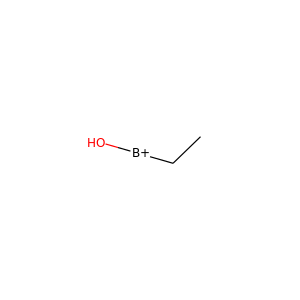

In [296]:
from rdkit.Chem import Draw

Draw.MolToImage(mol)